## 0. Import Libraries

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from xclim import sdba

import xclim

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

### 0.1 Exercises (Redundant)

https://xclim.readthedocs.io/en/stable/notebooks/sdba.html

In [2]:
t = xr.cftime_range("2000-01-01", "2030-12-31", freq="D", calendar="noleap")

In [3]:
vals = np.random.randint(0, 1000, size=(t.size,)) / 100
vals_ref = (4 ** np.where(vals < 9, vals / 100, vals)) / 3e6
vals_sim = (
    (1 + 0.1 * np.random.random_sample((t.size,)))
    * (4 ** np.where(vals < 9.5, vals / 100, vals))
    / 3e6
)

pr_ref = xr.DataArray(
    vals_ref, coords={"time": t}, dims=("time",), attrs={"units": "mm/day"}
)
pr_ref = pr_ref.sel(time=slice("2000", "2015"))
pr_sim = xr.DataArray(
    vals_sim, coords={"time": t}, dims=("time",), attrs={"units": "mm/day"}
)
pr_hist = pr_sim.sel(time=slice("2000", "2015"))

In [4]:
pr_hist

<xarray.DataArray (time: 5840)>
array([3.82309250e-07, 2.47231004e-01, 3.57477160e-07, ...,
       3.91664883e-07, 3.50336049e-07, 3.85657170e-07])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 00:00:00
Attributes:
    units:    mm/day

In [5]:
pr_sim

<xarray.DataArray (time: 11315)>
array([3.82309250e-07, 2.47231004e-01, 3.57477160e-07, ...,
       3.56126037e-07, 3.75042708e-07, 4.08203691e-07])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    units:    mm/day

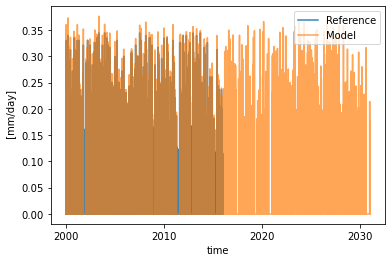

In [6]:
pr_ref.plot(alpha=0.9, label="Reference")
pr_sim.plot(alpha=0.7, label="Model")
plt.legend()

In [7]:
QM = sdba.EmpiricalQuantileMapping.train(pr_ref, pr_hist, nquantiles=15, kind="*", group="time")

In [8]:
scen = QM.adjust(pr_sim)

In [10]:
pr_sim

<xarray.DataArray (time: 11315)>
array([3.82309250e-07, 2.47231004e-01, 3.57477160e-07, ...,
       3.56126037e-07, 3.75042708e-07, 4.08203691e-07])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2030-12-31 00:00:00
Attributes:
    units:    mm d-1

In [18]:
scen_single = QM.adjust(pr_sim[-100:])

In [22]:
QM.ds.af

<xarray.DataArray 'af' (group: 1, quantiles: 15)>
array([[9.75031131e-01, 9.62698858e-01, 9.57974063e-01, 9.55625349e-01,
        9.53690951e-01, 9.54751877e-01, 9.54133927e-01, 9.52794039e-01,
        9.52409635e-01, 9.52008611e-01, 9.50360988e-01, 9.48842627e-01,
        9.44231995e-01, 2.16432385e+04, 9.56025534e-01]])
Coordinates:
  * quantiles  (quantiles) float64 0.03333 0.1 0.1667 ... 0.8333 0.9 0.9667
  * group      (group) int64 1
Attributes:
    units:          mm d-1
    kind:           *
    standard_name:  Adjustment factors
    long_name:      Quantile mapping adjustment factors

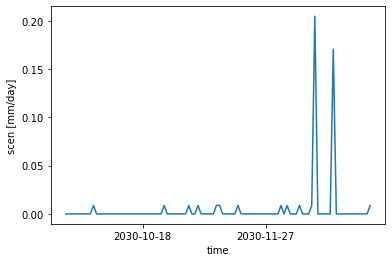

In [19]:
scen_single.plot()

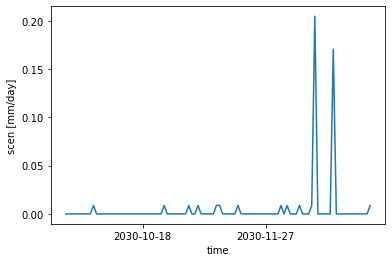

In [20]:
scen[-100:].plot()

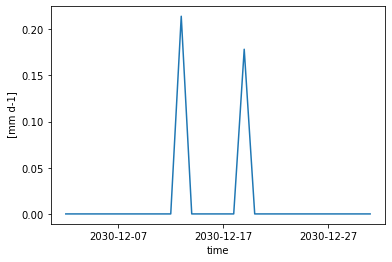

In [14]:
pr_sim[-30:].plot()

In [18]:
QM.ds

<xarray.Dataset>
Dimensions:    (quantiles: 15, group: 1)
Coordinates:
  * quantiles  (quantiles) float64 0.03333 0.1 0.1667 ... 0.8333 0.9 0.9667
  * group      (group) int64 1
Data variables:
    af         (group, quantiles) float64 0.9748 0.965 ... 2.196e+05 0.9546
    hist_q     (group, quantiles) float64 3.436e-07 3.505e-07 ... 0.2297
Attributes:
    group:               time
    group_compute_dims:  ['time']
    group_window:        1
    _xclim_adjustment:   {"py/object": "xclim.sdba.adjustment.EmpiricalQuanti...
    adj_params:          EmpiricalQuantileMapping(group=Grouper(name='time'),...

## 1. Open Data

In [2]:
path_general = r'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data'
season = 'DJF'

#### 1.1.1 Model

In [3]:
dt_model = xr.open_dataset(fr'{path_general}/cosmo/Tr011_MPI_RF_PR_{season}_1hr_198501_200512.nc',
                     chunks={"rlon": 20, "rlat":20})

In [4]:
dt_model

<xarray.Dataset>
Dimensions:   (time: 45480, rlat: 107, rlon: 175)
Coordinates:
  * time      (time) datetime64[ns] 1985-01-01 ... 2005-12-31T23:00:00
    lon       (rlat, rlon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    lat       (rlat, rlon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
  * rlon      (rlon) float32 -8.3 -8.19 -8.08 -7.97 ... 10.51 10.62 10.73 10.84
  * rlat      (rlat) float32 -6.2 -6.09 -5.98 -5.87 ... 5.13 5.24 5.35 5.46
Data variables:
    TOT_PREC  (time, rlat, rlon) float32 dask.array<chunksize=(45480, 20, 20), meta=np.ndarray>
Attributes: (12/13)
    CDI:                       Climate Data Interface version 1.9.10 (https:/...
    Conventions:               CF-1.4
    source:                    /home/yunal/cclm-sp-v3.1.1/src/cclm/cclm.exe}
    title:                     CCLM_v5.0_clm15 Simulation (0.11 Deg) with Med...
    experiment_id:             Tr0.11_RF
    realization:               1
    ...                        ...
    contact:                   Cemre Yuruk Sonuc (yurukc@itu.edu.tr)
    references:                http://www.clm-community.eu/
    creation_date:             2020-03-01 04:03:14
    nco_openmp_thread_number:  1
    history:                   Thu Dec 01 13:27:26 2022: cdo -select,season=D...
    CDO:                       Climate Data Operators version 1.9.10 (https:/...

#### 1.1.2 ERA5

dt_era5 = xr.open_dataset(fr'{path_general}/era5/era5_TOT_PREC_{season}_1hr_1985_2005.nc',
                     chunks={"time": 10})

In [5]:
dt_era5 = xr.open_dataset(fr'{path_general}/deneme.nc',
                     chunks={"rlon": 20, "rlat":20}, decode_cf=False)

#data.where(data!=nodata, np.nan)
dt_era5['tp'] = dt_era5['tp'].where(dt_era5['tp'] != dt_era5['tp'].attrs['missing_value'], 
                                    np.nan)
dt_era5['tp'] = (dt_era5['tp'] * dt_era5['tp'].attrs['scale_factor'] + dt_era5['tp'].attrs['add_offset'])
dt_era5['tp'] = dt_era5['tp'] * 1e3 # m to mm
dt_era5['time'] = dt_model['time']
dt_era5['tp'].attrs['units'] = 'mm'

In [6]:
dt_era5

<xarray.Dataset>
Dimensions:  (time: 45480, rlat: 107, rlon: 175)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-01 ... 2005-12-31T23:00:00
  * rlon     (rlon) float32 -8.3 -8.19 -8.08 -7.97 ... 10.51 10.62 10.73 10.84
  * rlat     (rlat) float32 -6.2 -6.09 -5.98 -5.87 -5.76 ... 5.13 5.24 5.35 5.46
Data variables:
    lon      (rlat, rlon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    lat      (rlat, rlon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    tp       (time, rlat, rlon) float64 dask.array<chunksize=(45480, 20, 20), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Jan 16 15:00:01 2023: cdo remapbil,cosmo/Tr011_MPI_RF_P...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

## 2. Create Bias Correction Coefficients

### 2.1 Train Quantile Mapping

In [7]:
QM = sdba.EmpiricalQuantileMapping.train(dt_era5['tp'], 
                                         dt_model['TOT_PREC'], 
                                         nquantiles=15, 
                                         kind="*", 
                                         group="time")

dt_model_qm = QM.adjust(dt_model['TOT_PREC'])

### 2.2 Save Coefficient Data

In [8]:
from dask.diagnostics import ProgressBar

delayed_obj = QM.ds.to_netcdf(fr"data/bias_correction/quantile_mapping_coefficients_{season}.nc", compute=False)

with ProgressBar():
    results = delayed_obj.compute()

[########################################] | 100% Completed | 41m 39s


In [1]:
QM

NameError: name 'QM' is not defined